# Import packages and aux functions

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import preprocessing, plotting
sns.set(style='darkgrid')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, balanced_accuracy_score
from sklearn.model_selection import (cross_validate, cross_val_predict,cross_val_score, train_test_split,
                                     GridSearchCV, RandomizedSearchCV, downsampledKFold, RandomizedSearchCV)
from pprint import pprint
from joblib import dump, load

ImportError: cannot import name 'downsampledKFold' from 'sklearn.model_selection' (/opt/conda/envs/data_literacy/lib/python3.10/site-packages/sklearn/model_selection/__init__.py)

In [4]:
def get_sorted_feat_importance(importance, feature_names):
    feature_importance = np.array(importance)
    feature_names = np.array(feature_names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df['cum_sum_fi']=fi_df['feature_importance'].cumsum()
    return fi_df

# Content
### 1. Load Data
- Questions Data
- Feature Data
### 2. Data Preprocessing
- Hyperparametertuning: Optimize Ratio: (Nr of feature)/(Train set size)
- Downsampling the dataset with chosen features
- Visualization of the feature distributions
- Feature Encoding: Label Encoding
### 3. Baseline Model: Naive Bayes
### 4. Random Forest Model
- Hyperparametertuning with RandomSearch
- Feature importance
### 5. Evaluation 
- Permutation Test
- Cross-Validation

# Load Data

In [5]:
# data loading
questions = pd.read_csv('data/question_data.csv', sep=';')
questions = questions.set_index('Unnamed: 0')  # set first column (question number) as index
questions.index.rename('q_id', inplace=True)
#questions.loc['gender', ['text', 'Keywords']] = ['gender?', 'descriptive'] # include gender as descriptive question

descriptive_questions = questions[questions['Keywords']=='descriptive'].index.to_list()
question_to_id = {question_id:i for i, question_id in enumerate(descriptive_questions)}
descriptive_questions = list(question_to_id.values())
questions.rename(index=question_to_id, inplace=True)
display(questions.loc[descriptive_questions].head())


,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q_id,,,,,,,,,
0,Which word describes you better?,Carefree,Intense,NaN,NaN,49827,N,NaN,descriptive
1,Have you ever seen a therapist?,Yes,No,NaN,NaN,9507,O,NaN,descriptive
2,Which describes you better?,Warm-hearted,Cool-headed,NaN,NaN,21205,O,NaN,descriptive
3,Are you a better conversationalist or listener?,Conversationalist,Listener,NaN,NaN,3174,O,NaN,descriptive
4,Which word describes you better?,Private,Social,NaN,NaN,23765,O,NaN,descriptive


In [6]:
data = pd.read_parquet('data/train.parquet')
political_belief = 'q212813'
data.rename({'q212813': 'political_belief', 'Unnamed: 0': 'user_id',**question_to_id}, axis=1, inplace=True)

# per question count number of times the question is answered
n_answers_per_question = data.loc[:, descriptive_questions].count(axis=0)
sorted_questions = n_answers_per_question.sort_values(ascending=False).index
question_data = questions.join(n_answers_per_question.to_frame('n_answers')) 
display(questions.loc[sorted_questions[:10]][['text']])

features_df = data[descriptive_questions]
print('Nr of rows, nr of descriptive questions', features_df.shape)

,text
789,Which type of wine would you prefer to drink o...
823,Do you like watching foreign movies with subti...
821,Do you enjoy intense intellectual conversations?
109,Have you smoked a cigarette in the last 6 months?
8,How frequently do you drink alcohol?
305,Rate your self-confidence:
373,How often do you keep your promises?
420,How often are you open with your feelings?
10,What's your deal with harder drugs (stuff beyo...
141,Are you happy with your life?


Nr of rows, nr of descriptive questions (36085, 829)


In [7]:
df_trn, df_val = train_test_split(data[descriptive_questions+ ['political_belief', 'gender', 'd_age']], test_size=0.1, random_state=1)
df_val = df_val[descriptive_questions+['political_belief']]

# Data preprocessing
To keep the train set reasonably big, we compute, how many questions we can include, s.t. that the nr. of subjects who answered these questions is at least 10.000. 


In [8]:
K=200
subset_size_topk = [features_df.loc[:, sorted_questions[:k]].dropna().shape[0] for k in range(1, K)]

In [9]:
# biggest k with >10.000 subjects who answered ALL k questions
min_train_size = np.arange(10, 25)*1000
n_most_answered = [next(x[0] for x in enumerate(subset_size_topk) if x[1] < min_set_size) for min_set_size in min_train_size]
n_most_answered

[49, 42, 37, 33, 28, 26, 24, 22, 19, 19, 18, 16, 15, 13, 12]

In [10]:
print(f'Shape of validation set before: {df_val.shape}')
top_questions = sorted_questions[:np.max(n_most_answered)].to_list()
df_val = df_val[top_questions+['political_belief']].dropna() 
print(f'Shape of validation set after selecting the top {np.max(n_most_answered)} questions: {df_val.shape}')

X_val = df_val[top_questions]
y_val = df_val[['political_belief']]

Shape of validation set before: (3609, 830)
Shape of validation set after selecting the top 49 questions: (987, 50)


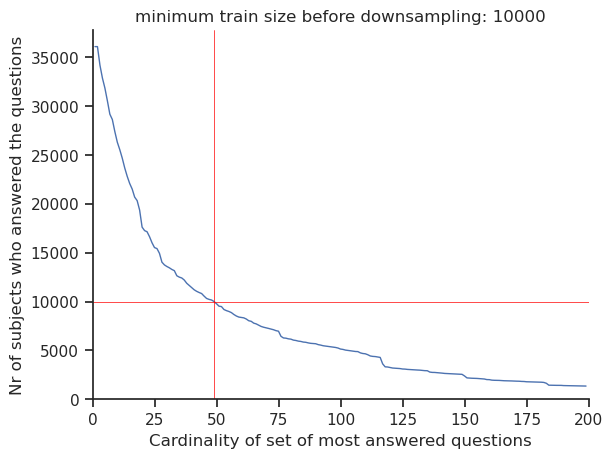

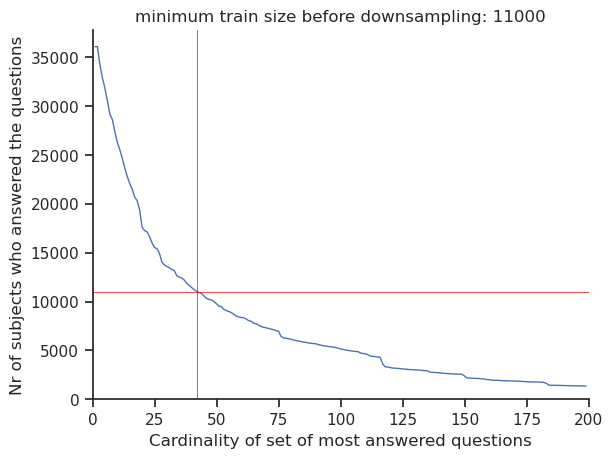

In [11]:
for n, min_size in zip(n_most_answered[:2], min_train_size):
    sns.set_style("white")
    sns.set_style("ticks")
    g = sns.lineplot(x = range(1,K), y = subset_size_topk, linewidth=1)
    g.axhline(y=min_size, color='red', linewidth=0.5)
    g.axvline(x=n, color='red', linewidth=0.5)

    plt.xlim(0, 200)
    plt.ylim(0)
    sns.despine()
    #plt.ylim(0,len(features_df))
    g.set(xlabel ="Cardinality of set of most answered questions", ylabel = "Nr of subjects who answered the questions")
    #title ='Nr of subjects who answered the same k most anwered questions '
    #plt.figtext(0.5, -0.1, 'Grouping most answered questions into a set, comparing the number of questions in the set to the number of subjects who answered all questions in the set', wrap=True, horizontalalignment='center', fontsize=12)
    plt.title(f'minimum train size before downsampling: {min_size}')
    plt.show()

## HPO: Optimize Ratio: (Nr of feature)/(Train set size)

In [12]:
val_scores = []

for n in n_most_answered:
    top_questions = sorted_questions[:n].to_list()
    filter_by = top_questions + ['political_belief']
    downsampled_df = df_trn[filter_by].dropna()
    n_conservative = downsampled_df.groupby('political_belief').count().iloc[1, 0]
    downsampled_df = downsampled_df.groupby('political_belief', group_keys=False).apply(lambda x: x.sample(n=n_conservative, random_state=1))


    # split into features and target
    features_df_downsampled = downsampled_df[top_questions]
    target = downsampled_df.loc[features_df_downsampled.index][['political_belief']]

    # encode train and validation set
    feature_encoder = OrdinalEncoder()
    target_encoder = LabelEncoder()
    # train set
    X_train_encoded = feature_encoder.fit_transform(features_df_downsampled)
    y_train_encoded = target_encoder.fit_transform(target.values.ravel())
    # val set
    X_val_encoded = feature_encoder.transform(X_val[top_questions])
    y_val_encoded = target_encoder.transform(y_val.values.ravel())

    # Naive Bayes Hyper parameter Tuning
    nb = CategoricalNB(fit_prior=False).fit(X_train_encoded, y_train_encoded)
    preds = nb.predict(X_val_encoded)
    val_scores.append(balanced_accuracy_score(y_val_encoded, preds))

best_nr_of_questions = n_most_answered[np.argmax(val_scores)]
print(f'Best balanced accuracy on the validation set obtained with {best_nr_of_questions} number of answered questions')

Best balanced accuracy on the validation set obtained with 19 number of answered questions


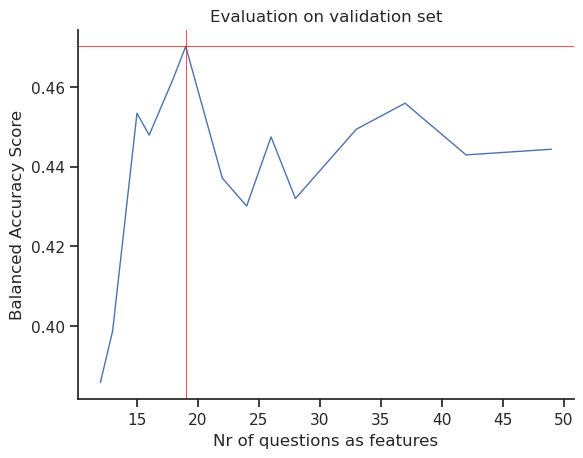

In [13]:
sns.set_style("white")
sns.set_style("ticks")
g = sns.lineplot(x = n_most_answered, y = val_scores, linewidth=1)
g.axhline(y=np.max(val_scores), color='red', linewidth=0.5)
g.axvline(x=best_nr_of_questions, color='red', linewidth=0.5)
sns.despine()
g.set(ylabel ='Balanced Accuracy Score', xlabel ='Nr of questions as features', title='Evaluation on validation set')
plt.show()

## Downsampling the dataset with chosen features

In [16]:
top_questions = sorted_questions[:best_nr_of_questions].to_list()
filter_by = top_questions + ['political_belief', 'd_age', 'gender']
downsampled_df = data[filter_by].dropna()
n_conservative = downsampled_df.groupby('political_belief').count().iloc[1, 0]
downsampled_df = downsampled_df.groupby('political_belief', group_keys=False).apply(lambda x: x.sample(n=n_conservative, random_state=1))
display(downsampled_df.head())

,789,823,821,109,8,305,373,420,10,141,...,268,198,818,331,500,296,299,political_belief,d_age,gender
index,,,,,,,,,,,,,,,,,,,,,
33759,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Yes,No,Sometimes,Average,Always,Always,I never do drugs.,Yes,...,Knowledge,Twice or more a day,Somewhat important,No,I am my own person.,Yes,Rarely / never,Centrist,57.0,Man
63922,"Red (such as Merlot, Cabernet, Shiraz).",Yes,Yes,No,Sometimes,Higher than average,Always,Rarely,"I've done drugs in the past, but no longer.",Yes,...,Knowledge,Twice or more a day,A little important,Yes,I am my own person.,Yes,Sometimes,Centrist,25.0,Man
64862,"Red (such as Merlot, Cabernet, Shiraz).",Yes,Yes,No,Rarely,Higher than average,Whenever possible,Always,I never do drugs.,Yes,...,Knowledge,Twice or more a day,Somewhat important,No,I am my own person.,Yes,Rarely / never,Centrist,32.0,Man
33396,Rosé (such as White Zinfindel).,Yes,Yes,Yes,Sometimes,Higher than average,Always,Always,"I've done drugs in the past, but no longer.",Yes,...,Knowledge,Twice or more a day,Somewhat important,Yes,I consider their opinion but go my own way.,Yes,Sometimes,Centrist,39.0,Man
47789,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Yes,No,Rarely,Higher than average,Always,Usually,I never do drugs.,Yes,...,Knowledge,Twice or more a day,Very important,No,I am my own person.,Yes,Sometimes,Centrist,31.0,Man


## Visualize of the feature distribution

In [26]:
print(top_questions)

[789, 823, 821, 109, 8, 305, 373, 420, 10, 141, 9, 0, 268, 198, 818, 331, 500, 296, 299]


In [47]:
#add missing entries in 'Order' column
for index, row in questions.iterrows():
    if type(row['Order'])!=list:   
        order = [row['option_1'], row['option_2']]
        if isinstance(row['option_3'], str):
            order.append(row['option_3'])
        if isinstance(row['option_4'], str):
            order.append(row['option_4'])
        questions.at[index, 'Order']=order

#manually fix strange entries
questions.at[296, 'Order']=['Yes', 'Sometimes', 'No']
questions.at[299, 'Order']=['All the time', 'Sometimes', 'Rarely / never']

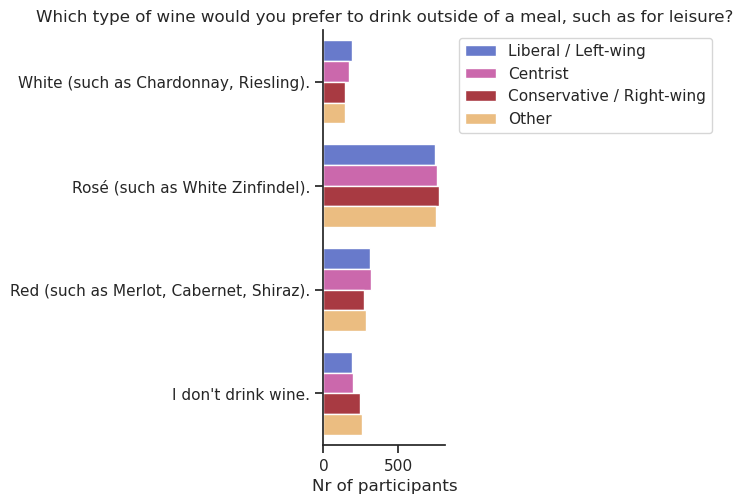

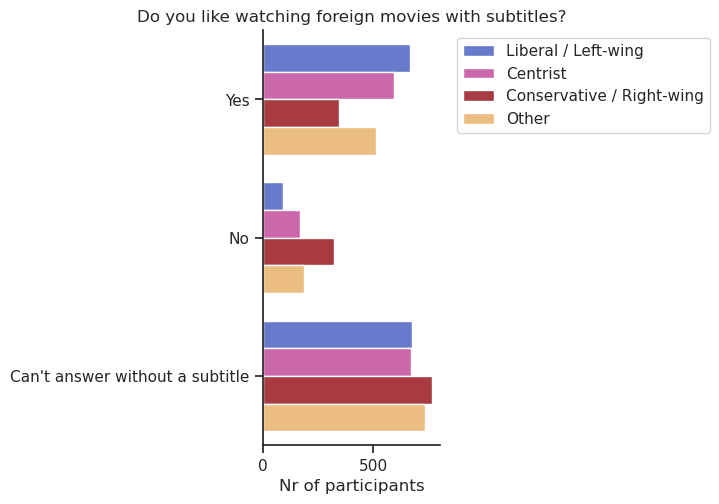

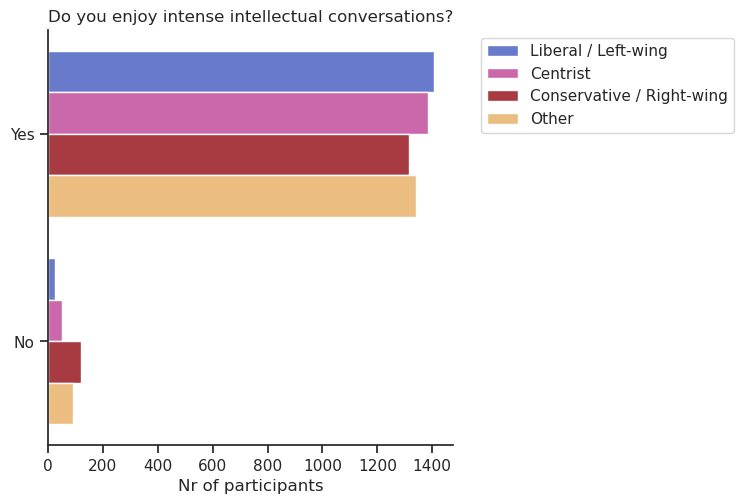

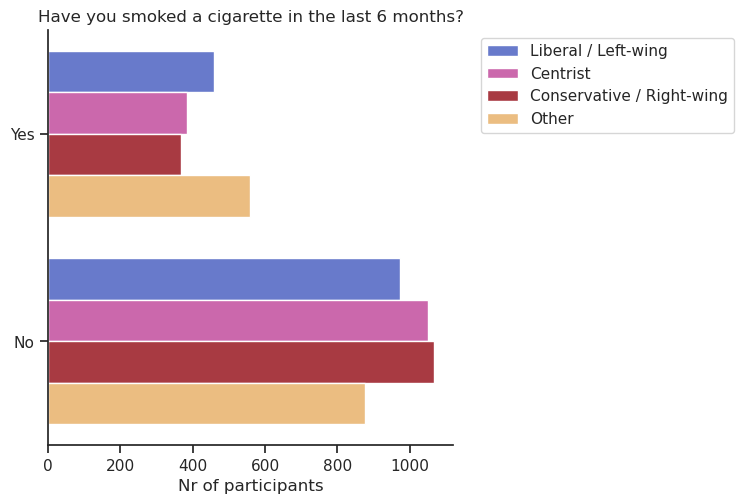

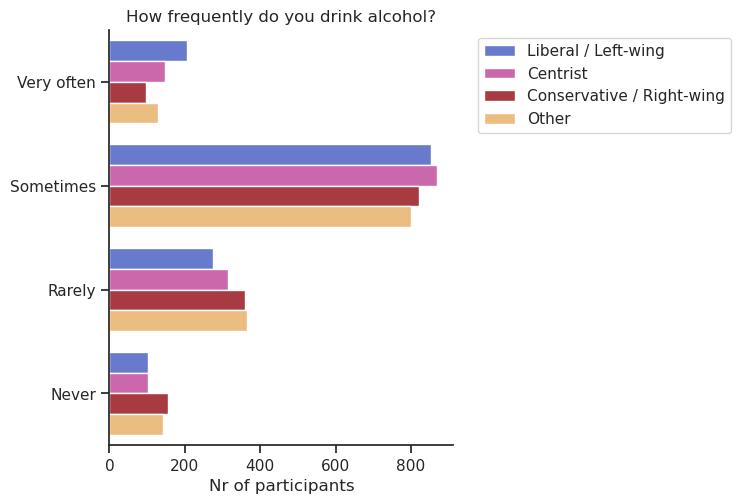

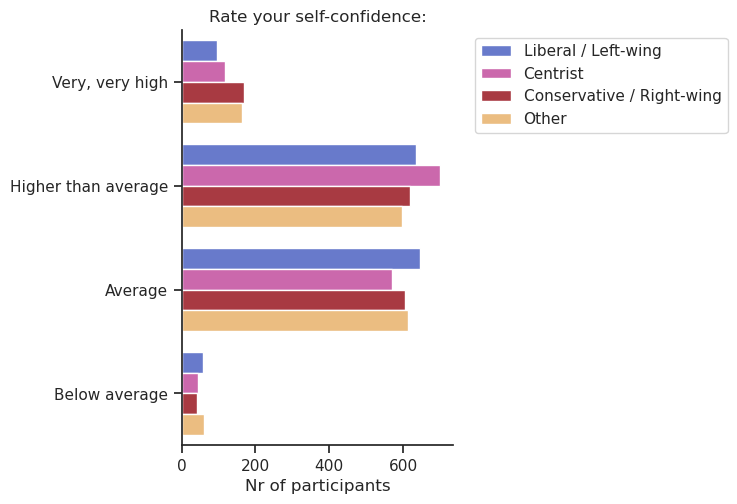

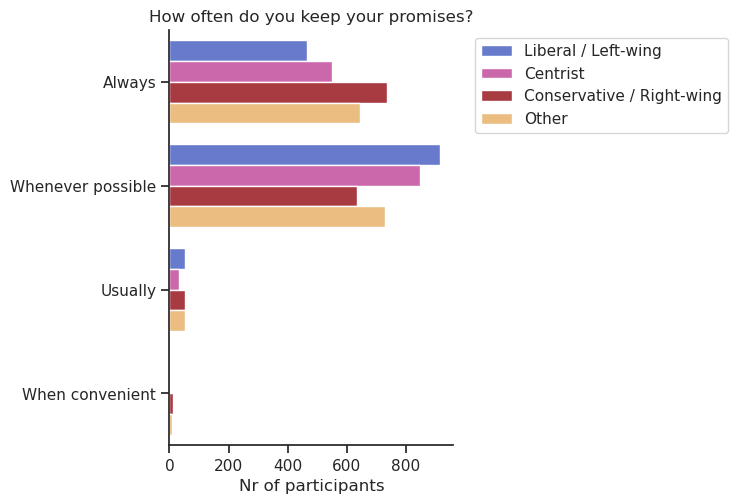

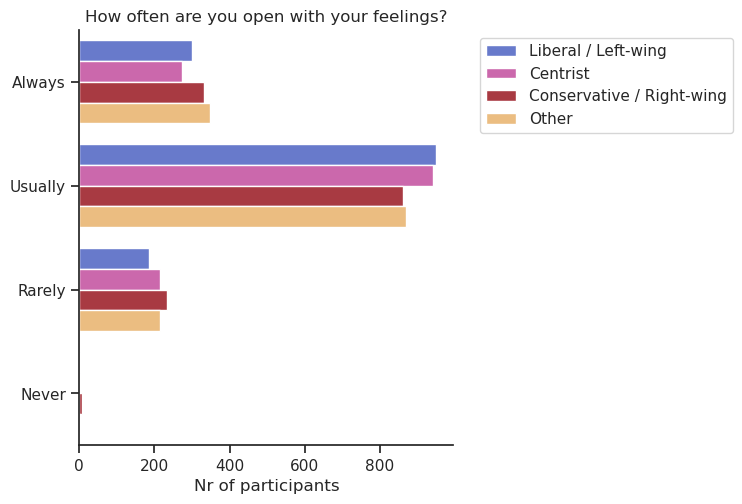

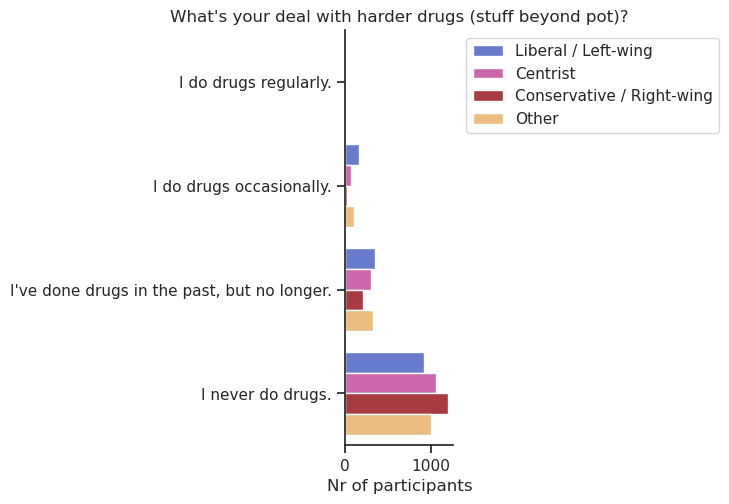

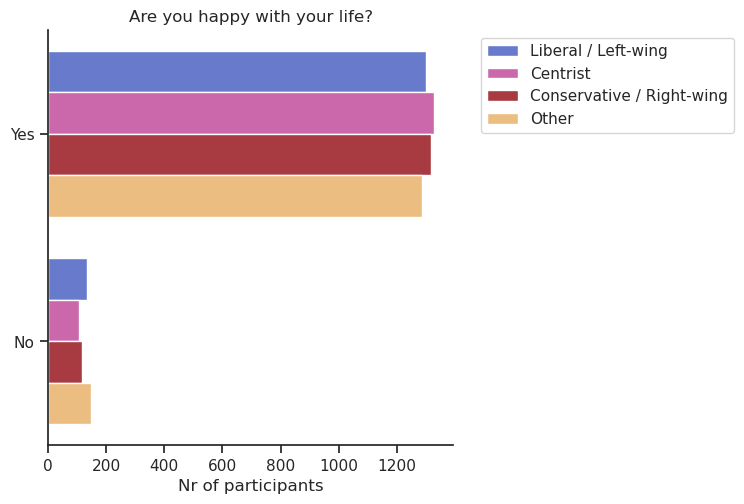

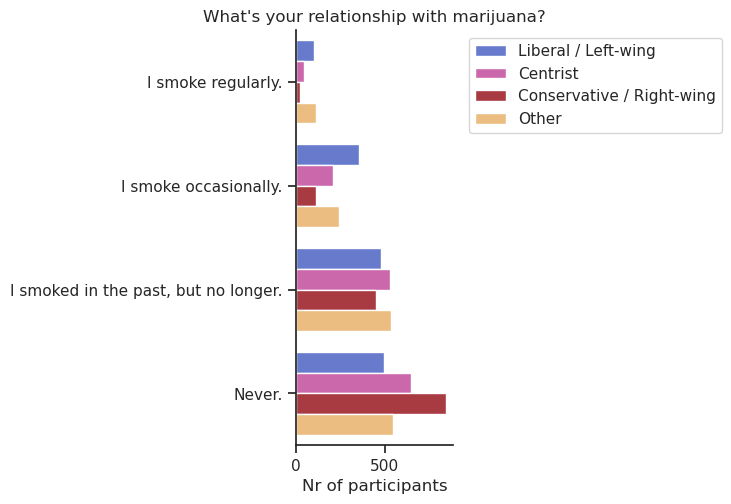

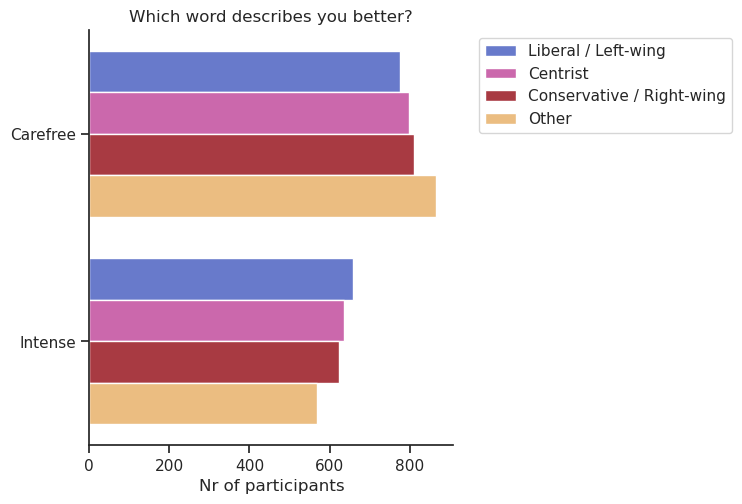

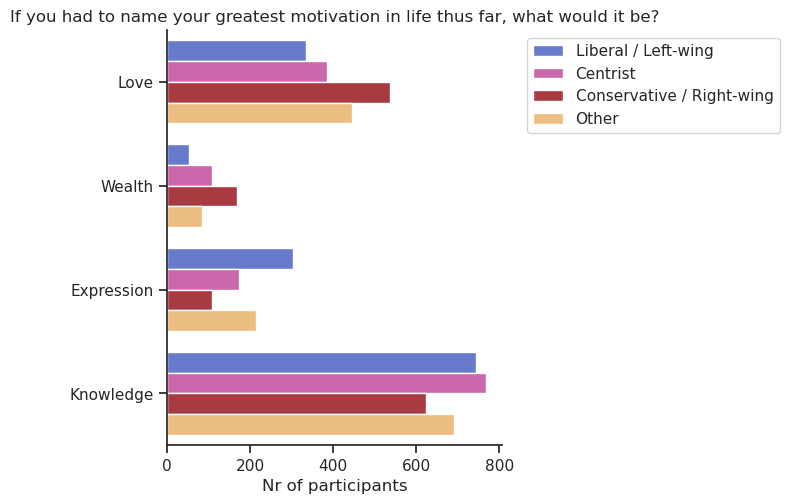

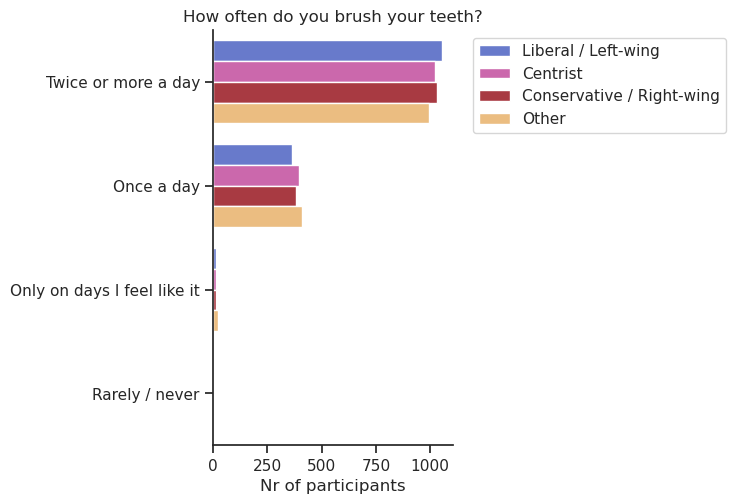

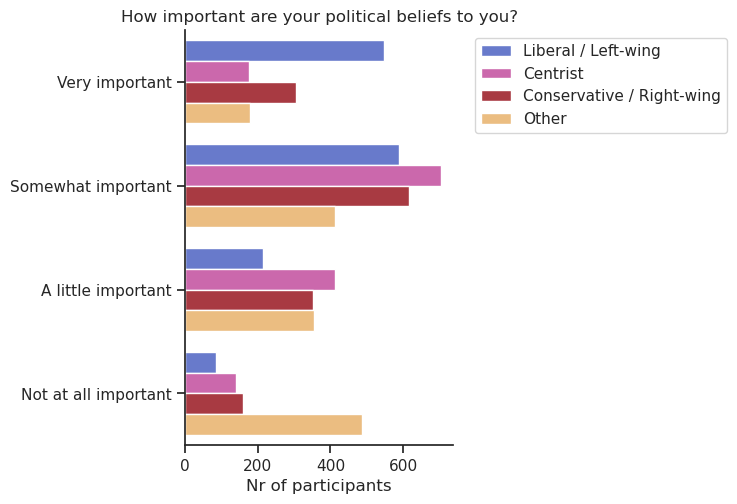

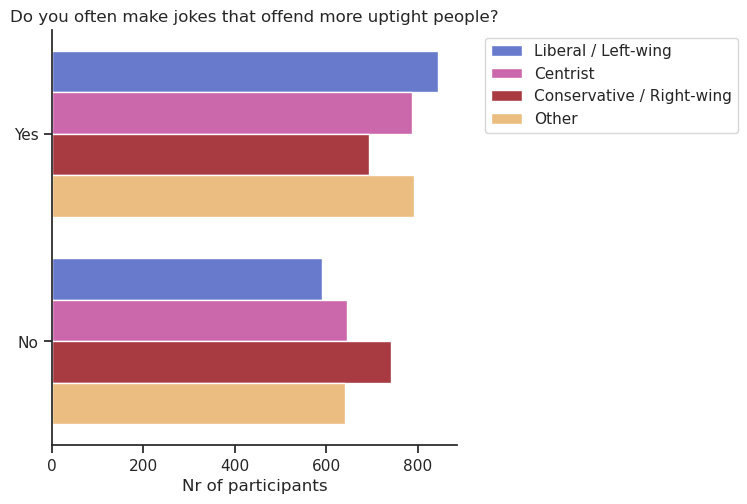

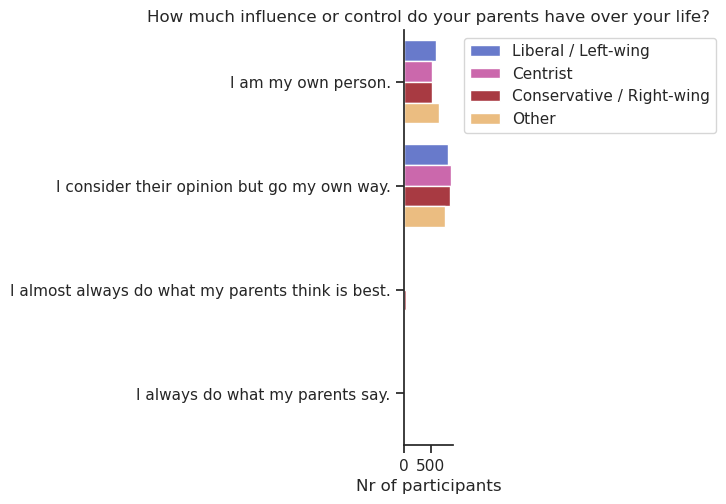

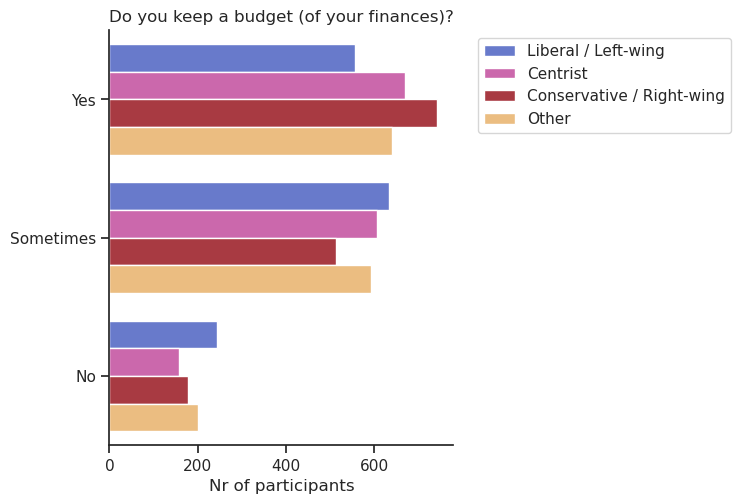

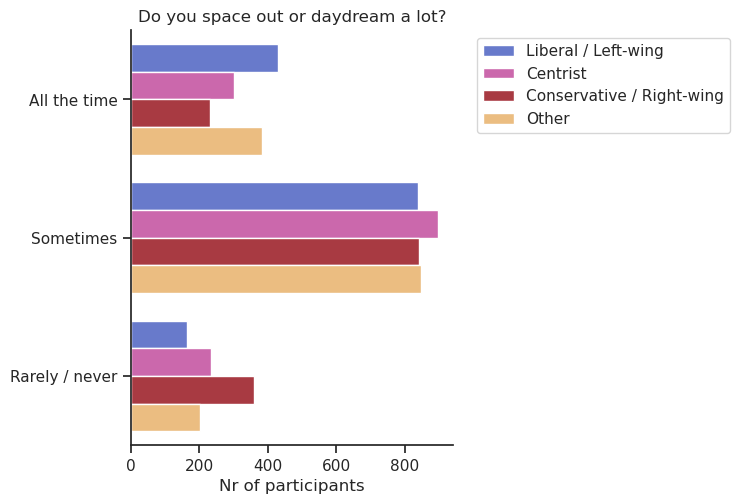

In [77]:
def plot_question_distribution(question: str, data: pd.DataFrame, questions: pd.DataFrame):
    """plots histogram of polical orientation for a given question"""
#    plt.figure()
    title = questions.loc[question, 'text']
        
    s = sns.catplot(
        data=data, y=question, kind="count", hue='political_belief', 
        palette={'Liberal / Left-wing': '#5770db', 'Centrist': '#db57b2', 'Conservative / Right-wing': '#ba2832', 'Other': '#fdbf6f'}, 
        hue_order= ['Liberal / Left-wing', 'Centrist', 'Conservative / Right-wing', 'Other'], 
        order = questions.loc[question, 'Order'],
        legend = False,
    ).set(xlabel ="Nr of participants", ylabel = "", title=title)
    plt.legend(title="", bbox_to_anchor=(1.05, 1.0), loc='upper left')
#    plt.savefig(fname='./figures/'+title, bbox_inches='tight')
#    plt.close()

for question in top_questions:
    plot_question_distribution(question, downsampled_df, questions)

## Feature Encoding: Label encoding

In [14]:
# split into features and target
features_df = downsampled_df[top_questions]
target = downsampled_df.loc[features_df.index][['political_belief']]

In [15]:
feature_encoder = OrdinalEncoder()
target_encoder = LabelEncoder()
X_train_encoded = feature_encoder.fit_transform(features_df)
y_train_encoded = target_encoder.fit_transform(target.values.ravel())

# Baseline Model: Naive Bayes

In [40]:
nb = CategoricalNB(fit_prior=False).fit(X_train_encoded, y_train_encoded)
scores = cross_val_score(nb, X_train_encoded, y_train_encoded, cv=5, scoring='balanced_accuracy')
print(f"balanced accuracy with mean: {scores.mean()} a standard deviation of {scores.std()}")

balanced accuracy with mean: 0.4447807797132361 a standard deviation of 0.005232540910207079


In [42]:
# Save model
dump(nb, 'models/nv_downsampled_trn_set.joblib') 

['models/nv_downsampled_trn_set.joblib']

# Random Forest Classifier
## Hyperparameter Tuning
HPT using Random Search with downsampled K-fold crossvalidation \
Chosen scoring metrics: balanced accuracy (average of recall obtained on each class)

In [25]:
# Choose parameter distributions
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1500, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
pprint(param_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 525, 850, 1175, 1500]}


In [26]:
rf = RandomForestClassifier(class_weight='balanced', random_state=1)
rf_random = RandomizedSearchCV(estimator = rf,
                             param_distributions = param_grid, 
                             n_iter = 100, 
                             cv = 3, 
                             verbose=2, 
                             random_state=42, 
                             n_jobs = -1, 
                             scoring='balanced_accuracy')
rf_random.fit(X_train_encoded, y_train_encoded)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=5, n_estimators=525; total time=  13.8s
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=5, n_estimators=525; total time=  13.9s
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=5, n_estimators=525; total time=  13.9s
[CV] END max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   5.7s
[CV] END max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   5.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=1175; total time=  29.4s
[CV] END max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   4.8s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   5.2s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   5.0s
[CV] END max_depth

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 525, 850, 1175,
                                                         1500]},
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [37]:
print('Results of parameter tuning with random search:')
# best_random_params={'max_depth': 10,
#  'min_samples_leaf': 4,
#  'min_samples_split': 5,
#  'n_estimators': 1000}
best_random_params = rf_random.best_params_
pprint(best_random_params)

Results of parameter tuning with random search:
{'max_depth': 20,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1175}


In [32]:
# rf_tuned = RandomForestClassifier(**best_random_params).fit(X_train_encoded, y_train_encoded)
# scores = cross_val_score(rf_tuned, X_train_encoded, y_train_encoded, cv=5, scoring='balanced_accuracy')
# print("%0.2f Balanced accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

rf_tuned = rf_random.best_estimator_
scores = cross_val_score(rf_tuned, X_train_encoded, y_train_encoded, cv=5, scoring='balanced_accuracy')
print(f"balanced accuracy with mean: {scores.mean()} a standard deviation of {scores.std()}")

balanced accuracy with mean: 0.4430619741675554 a standard deviation of 0.00882277255315826


In [43]:
# save model
dump(rf_tuned, 'models/rf_downsampled_trn_set.joblib') 

['models/rf_downsampled_trn_set.joblib']

## Visualize feature importance

In [34]:
fi_df = get_sorted_feat_importance(rf_tuned.feature_importances_, features_df.columns)
print('Top 20 Features sorted by their gini impotance scores ')
for i, row in fi_df[:20].iterrows():
    print(f"Feature {row['feature_names']}: {questions.loc[row['feature_names']].text}: {row['feature_importance']}")

Top 20 Features sorted by their gini impotance scores 
Feature 818: How important are your political beliefs to you?: 0.15420508707221356
Feature 9: What's your relationship with marijuana?: 0.07052018809222632
Feature 268: If you had to name your greatest motivation in life thus far, what would it be?: 0.06962775411474739
Feature 823: Do you like watching foreign movies with subtitles?: 0.06370837797221006
Feature 789: Which type of wine would you prefer to drink outside of a meal, such as for leisure?: 0.0630279380173858
Feature 305: Rate your self-confidence:: 0.061917798539476696
Feature 296: Do you keep a budget (of your finances)?: 0.054481036822456454
Feature 8: How frequently do you drink alcohol?: 0.05444871024185651
Feature 299: Do you space out or daydream a lot?: 0.05435185120801385
Feature 420: How often are you open with your feelings?: 0.05273790109904444
Feature 373: How often do you keep your promises?: 0.04742866782245648
Feature 500: How much influence or control do 

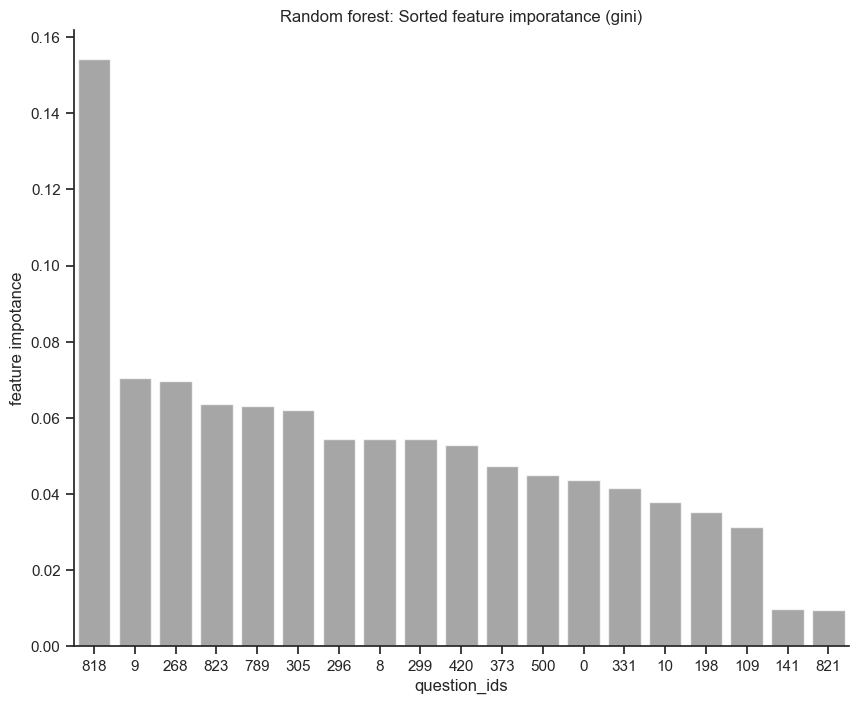

In [35]:
#Define size of bar plot
plt.figure(figsize=(10,8))
sns.set_style("white")
sns.set_style("ticks")
#Plot Searborn bar chart
g = sns.barplot(y=fi_df['feature_importance'].values, x=np.arange(len(fi_df.index)), color='gray', alpha=0.7)
sns.despine()

g.set_xticklabels(fi_df['feature_names'])
#Add chart labels
g.set_title('Random forest: Sorted feature imporatance (gini)')
g.set(ylabel ='feature impotance', xlabel ='question_ids')
plt.show()

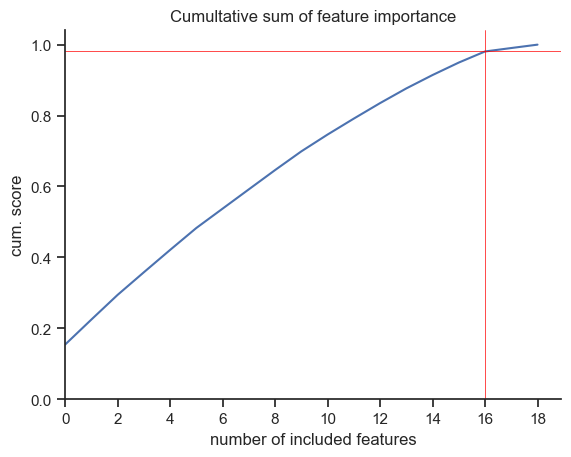

In [36]:
# first top k question, s.t. Cumultative sum of feature importance is >=.95
cum_sum_top_k = next(x[0] for x in enumerate(fi_df.cum_sum_fi) if x[1] >=0.95)

sns.set_style("white")
sns.set_style("ticks")
g = sns.lineplot(x = np.arange(len(fi_df)), y = fi_df['cum_sum_fi'])
g.axhline(y=fi_df['cum_sum_fi'].iloc[cum_sum_top_k], color='red', linewidth=0.5)
g.axvline(x=cum_sum_top_k, color='red', linewidth=0.5)
sns.despine()
plt.ylim(0)
plt.xlim(0)
g.set(xlabel='number of included features', ylabel='cum. score', title='Cumultative sum of feature importance', xticks=np.arange(len(fi_df), step=2))
plt.show()

# Evaluation

## Permutatin Test

## Cross Validation 